In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (700000, 26)
Test shape: (300000, 25)


In [3]:
train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
test.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


In [5]:
# Basic info
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [7]:
# Check missing values (should be all zeros in this comp)
missing_counts = train.isnull().sum().sort_values(ascending=False)
print("Missing values (top 20):")
print(missing_counts.head(20))


Missing values (top 20):
id                         0
age                        0
cardiovascular_history     0
hypertension_history       0
family_history_diabetes    0
employment_status          0
smoking_status             0
income_level               0
education_level            0
ethnicity                  0
gender                     0
triglycerides              0
ldl_cholesterol            0
hdl_cholesterol            0
cholesterol_total          0
heart_rate                 0
diastolic_bp               0
systolic_bp                0
waist_to_hip_ratio         0
bmi                        0
dtype: int64


diagnosed_diabetes
1.0    436307
0.0    263693
Name: count, dtype: int64
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


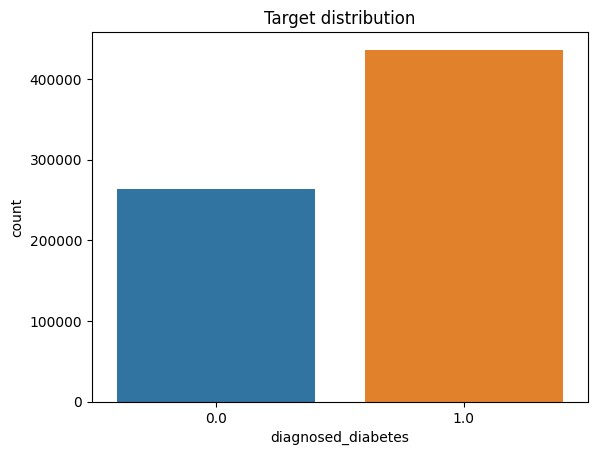

In [8]:
TARGET = "diagnosed_diabetes"
ID_COL = "id"



# Target distribution
print(train[TARGET].value_counts())
print(train[TARGET].value_counts(normalize=True))

sns.countplot(x=TARGET, data=train)
plt.title("Target distribution")
plt.show()


## Feature matrices & categoricals

In [9]:
# Prepare X, y, test, and categorical features

X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

X_test_raw = test.drop(columns=[ID_COL])
test_ids = test[ID_COL].copy()

# Identify categorical features (based on earlier exploration)
categorical_features = [
    'gender',
    'ethnicity',
    'education_level',
    'income_level',
    'smoking_status',
    'employment_status'
]

# Ensure dtype 'category' for LightGBM
for col in categorical_features:
    X[col] = X[col].astype("category")
    X_test_raw[col] = X_test_raw[col].astype("category")

print("Categorical features:", categorical_features)


Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [10]:
# LightGBM K-Fold training


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds_lgb = np.zeros(len(X))
test_preds_lgb = np.zeros(len(X_test_raw))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== LightGBM Fold {fold+1} =====")
    
    X_train_f, X_valid_f = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_f, y_valid_f = y.iloc[train_idx], y.iloc[valid_idx]
    
    model_lgb = lgb.LGBMClassifier(
        objective="binary",
        metric="auc",
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=40,
        subsample=0.8,        # row sampling
        colsample_bytree=0.8, # feature sampling
        n_jobs=-1,
        random_state=42
    )
    
    model_lgb.fit(
        X_train_f, y_train_f,
        eval_set=[(X_valid_f, y_valid_f)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(100)
        ]
    )
    
    valid_pred = model_lgb.predict_proba(X_valid_f)[:, 1]
    oof_preds_lgb[valid_idx] = valid_pred
    
    test_preds_lgb += model_lgb.predict_proba(X_test_raw)[:, 1] / kf.n_splits

oof_auc_lgb = roc_auc_score(y, oof_preds_lgb)
print("\nOverall LightGBM CV ROC-AUC:", oof_auc_lgb)



===== LightGBM Fold 1 =====
[LightGBM] [Info] Number of positive: 349045, number of negative: 210955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623295 -> initscore=0.503556
[LightGBM] [Info] Start training from score 0.503556
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.718661
[200]	valid_0's auc: 0.723543
[300]	valid_0's auc: 0.725051
[400]	valid_0's auc: 0.725912
[500]	valid_0's auc: 0.726628
[600]	valid_0's auc: 0.726992
[700]	valid_0's auc: 0.727249
[800]	valid_0's auc: 0.72732
[900]	valid_0's auc: 0.727355
[1000]	valid_0's auc: 0.727551
Did not meet early stopping. Best iteration is:
[9

In [11]:
# ============================================================
# SECTION 4: CatBoost K-Fold training
# ============================================================

oof_preds_cb = np.zeros(len(X))
test_preds_cb = np.zeros(len(X_test_raw))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== CatBoost Fold {fold+1} =====")
    
    X_train_f, X_valid_f = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_f, y_valid_f = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train_f, label=y_train_f, cat_features=categorical_features)
    valid_pool = Pool(X_valid_f, label=y_valid_f, cat_features=categorical_features)
    test_pool  = Pool(X_test_raw, cat_features=categorical_features)
    
    model_cb = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        depth=6,
        learning_rate=0.05,
        iterations=600,
        l2_leaf_reg=5,
        random_seed=42,
        verbose=False,
        task_type="CPU"
    )
    
    model_cb.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )
    
    valid_pred = model_cb.predict_proba(valid_pool)[:, 1]
    oof_preds_cb[valid_idx] = valid_pred
    
    test_preds_cb += model_cb.predict_proba(test_pool)[:, 1] / kf.n_splits

oof_auc_cb = roc_auc_score(y, oof_preds_cb)
print("\nOverall CatBoost CV ROC-AUC:", oof_auc_cb)



===== CatBoost Fold 1 =====

===== CatBoost Fold 2 =====

===== CatBoost Fold 3 =====

===== CatBoost Fold 4 =====

===== CatBoost Fold 5 =====

Overall CatBoost CV ROC-AUC: 0.7223224642199281


In [14]:
# Ensemble of LightGBM + CatBoost

# 50/50
oof_ens_50 = 0.5 * oof_preds_lgb + 0.5 * oof_preds_cb
cv_auc_ens_50 = roc_auc_score(y, oof_ens_50)
print("Ensemble (0.5 LGBM + 0.5 CatBoost) CV ROC-AUC:", cv_auc_ens_50)

# 40/60 LightGBM
oof_ens_60 = 0.6 * oof_preds_lgb + 0.4 * oof_preds_cb
cv_auc_ens_60 = roc_auc_score(y, oof_ens_60)
print("Ensemble (0.6 LGBM + 0.4 CatBoost) CV ROC-AUC:", cv_auc_ens_60)

# 30/70
oof_ens_70 = 0.7 * oof_preds_lgb + 0.3 * oof_preds_cb
cv_auc_ens_70 = roc_auc_score(y, oof_ens_70)
print("Ensemble (0.7 LGBM + 0.3 CatBoost) CV ROC-AUC:", cv_auc_ens_70)

# 20/80
oof_ens_80 = 0.8 * oof_preds_lgb + 0.2 * oof_preds_cb
cv_auc_ens_80 = roc_auc_score(y, oof_ens_80)
print("Ensemble (0.8 LGBM + 0.2 CatBoost) CV ROC-AUC:", cv_auc_ens_80)

Ensemble (0.5 LGBM + 0.5 CatBoost) CV ROC-AUC: 0.725625840530244
Ensemble (0.6 LGBM + 0.4 CatBoost) CV ROC-AUC: 0.7260308628054835
Ensemble (0.7 LGBM + 0.3 CatBoost) CV ROC-AUC: 0.7263580521363728
Ensemble (0.8 LGBM + 0.2 CatBoost) CV ROC-AUC: 0.7266105285712605


## Selecting Ensemble Method for Submission

In [15]:
# Choose weights based on CV
w_lgb = 0.8
w_cb = 0.2

test_preds_ens = w_lgb * test_preds_lgb + w_cb * test_preds_cb

submission_ens = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: test_preds_ens
})

submission_ens.to_csv("submission_ensemble_lgbm_catboost.csv", index=False)
print("Saved submission_ensemble_lgbm_catboost.csv")
submission_ens.head()


Saved submission_ensemble_lgbm_catboost.csv


,id,diagnosed_diabetes
0,700000,0.508797
1,700001,0.680699
2,700002,0.780822
3,700003,0.400798
4,700004,0.911424
